In [16]:
# ### For Colab, install dependencies.

# !pip install prophet
# !pip install fredapi
# !pip install stats-can
# !pip install --upgrade scikit-learn

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
# %cd /content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
# !pwd

In [19]:
import prophet
from prophet import Prophet

import pandas as pd
pd.set_option('precision', 3)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [20]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/prophet_202110"

## Load Data Using APIs

In [21]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

# foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = pd.read_csv("./data_files/food_cpi.csv")
foodprice_df = foodprice_df.set_index("REF_DATE")
foodprice_df.index = pd.DatetimeIndex(foodprice_df.index)
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-04-01,156.2,146.1,145.1,163.2,155.4,141.9,173.5,140.5,151.1
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4


# Prophet Model and Experiments

Though Prophet supports the incorporation of additional regressors, it does not explicitly support *lagged* regressors. That is, in order to produce forecasts that use additional regressors, the future value of those regressors must be known or assumed.

For example, if we add CAD-USD exchange rates as a regressor to the model, then we would need to supply future values of that regressor for as far into the future we are forecasting. Obviously we don't know what those future values will be, but perhaps in another experiment, we could assume those values. 

Another option would be to hack the model by lagging the regressors ourselves. We would do this by creating an additional regressor with a lag period equal to or grather than the forecast period of 18 months, the logic being that in 18 months, we will know what the value of any regressor was 18 months ago, or more than 18 months ago.

I don't like this approach as much (for linear models) because it introduces many more variables into the experiment: for any additional regressor, what are the optimal lags to use? And should we even use those variables in the first place? In any case, these are experiments that we could implement, as long as we are extremely consistent about forecast evaluation on our validation set. For now, let's just focus on the baseline autoregressive forecasts using Prophet, in its intended configuration.

## Data Splitting

For each such candidate forecast, we should record any uncertainty/confidence metrics it provides, and evaluation metrics for that same model configuration over the test set. i.e. When model configuration XYZ was used to forecast Meat prices over the test set (with that data not being used for training or validation!) - what were its evaluation metrics on the withheld data? We should report this consistently for ALL EXPERIMENTS. 

For all models, we will use the following "simulated" report dates. This is a form of cross validation over time. We train a model up to each cutoff date, and then produce and evaluate 18-month forecasts. We can then collect each model's validation metric, take the mean, and use this to do model selection for the final forecast (or ensemble of forecasts!).

In [22]:
report_sim_dates = ["2015-07-01", "2016-07-01", "2017-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]

In [23]:
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

In [24]:
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', food_category:'y'}, axis=1)
    return df

In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

## Fitting and Evaluating a Single Prophet Model: Example Using Meat CPI

In [26]:
report_sim_date = "2016-07-01"
report_train_dates = sim_train_dates[report_sim_date]
report_valid_dates = sim_valid_dates[report_sim_date]
train_df = get_prophet_df(foodprice_df, 'Meat', report_train_dates)
train_df

,ds,y
0,1986-01-01,65.1
1,1986-02-01,64.2
2,1986-03-01,64.2
3,1986-04-01,63.6
4,1986-05-01,64.0
...,...,...
362,2016-03-01,160.0
363,2016-04-01,158.7
364,2016-05-01,159.1
365,2016-06-01,156.7


In [27]:
model = Prophet()
model.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.3323


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1338.9     0.0056426       387.734           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1356.36    0.00231409       515.838      0.3764      0.3764      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.97   0.000670033       585.482      0.5552      0.5552      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1366.7    0.00174566       546.655      0.9012      0.9012      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421        1367.8   0.000116691       330.655   4.135e-07       0.001      540  LS failed, Hessian reset 
     499        1369.8   0.000926603       97.6011           1           1      6

In [28]:
valid_df = get_prophet_df(foodprice_df, 'Meat', report_valid_dates)
valid_forecast = model.predict(valid_df[['ds']])

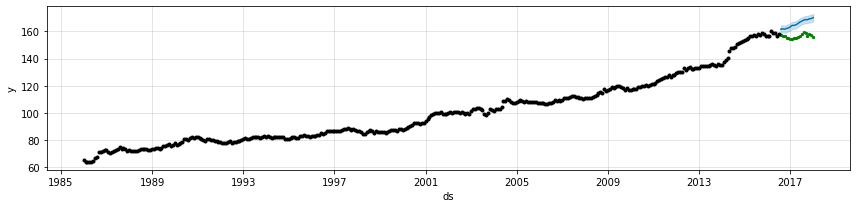

In [29]:
# valid_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig = model.plot(valid_forecast, figsize=(12,3))
fig.axes[0].scatter(valid_df.ds, valid_df.y, color='green', s=5)
pass

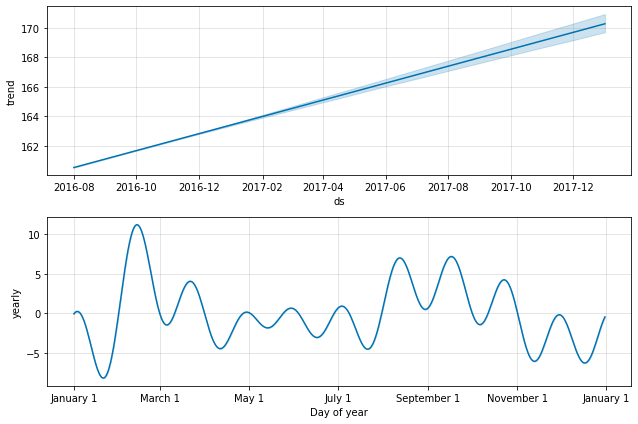

In [30]:
model.plot_components(valid_forecast)
pass

In [31]:
{metric_name: metric_fn(y_true=valid_df.y, y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

{'r2_score': -41.60989034851973,
 'mae': 9.15034897351521,
 'mape': 0.05848829854822598,
 'mse': 89.91738959595668,
 'rmse': 9.482478030344003}

## Fit and Evaluate Models for All CPI Categories (Validation)

In [32]:
def fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates):
    train_df = get_prophet_df(foodprice_df, food_category, train_dates)     # Select training data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    valid_df = get_prophet_df(foodprice_df, food_category, valid_dates)     # Select the validation data. 
    valid_forecast = model.predict(valid_df[['ds']])                        # Produce the validation period forecast. 

    valid_metrics = {metric_name: metric_fn(y_true=valid_df.y,              # Compute validation metrics. 
                                      y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

    return model, valid_forecast, valid_metrics

In [33]:
def plot_valid_forecast(model, food_category, sim_forecast_date, valid_forecast, valid_actual):

    fig = model.plot(valid_forecast, figsize=(10,4))
    ax = fig.axes[0]
    ax.scatter(valid_actual.ds, valid_actual.y, color='green', s=10, label='Actual CPI')
    ax.set_title(f'CPI Forecast (Simulated From {date}) - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.png", bbox_inches='tight')
    plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.7612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1339.5    0.00118661       353.076           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1363.62     0.0114838       545.985      0.5001           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1375.54   0.000528332       157.989           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1378.75   0.000412246       143.779      0.7415      0.7415      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1380.05   3.93882e-05        129.64           1           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha   

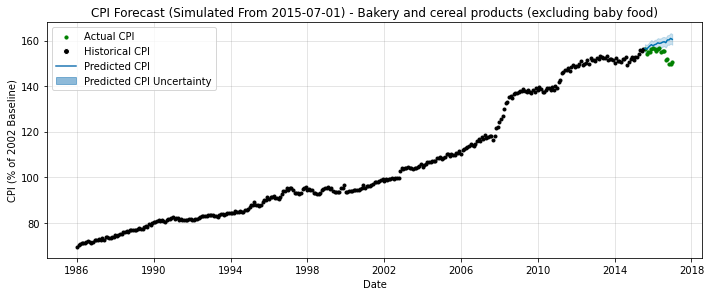

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.430
mae          4.427
mape         0.029
mse         31.379
rmse         5.602
dtype: float64
Initial log joint probability = -2.59973
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1372.98    0.00485082       685.766           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1398.19   0.000581895        423.42           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1414.79   0.000962456       196.567           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       1415.98   4.45652e-05       176.551   2.684e-07       0.001      428  LS failed, Hessian reset 
     399       1417.97    0.00611527        425.75           1           1      506   
    Iter      log prob

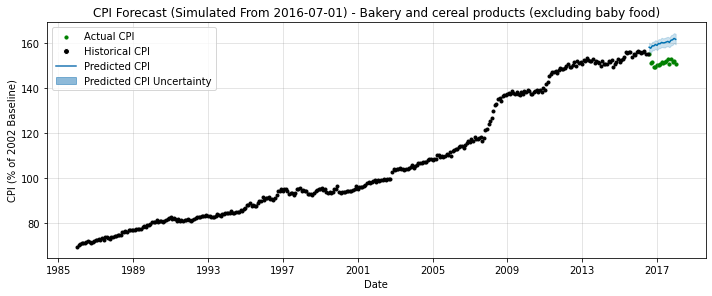

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -44.357
mae          8.617
mape         0.057
mse         77.169
rmse         8.785
dtype: float64
Initial log joint probability = -2.48661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1392.3    0.00739912       163.816           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1410.98    0.00119277       169.725           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1413.59   2.89291e-05       104.644   1.688e-07       0.001      309  LS failed, Hessian reset 
     283       1415.91   5.89599e-05       186.231    5.07e-07       0.001      407  LS failed, Hessian reset 
     299       1416.55   5.31625e-05       142.626      0.5853      0.5853      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

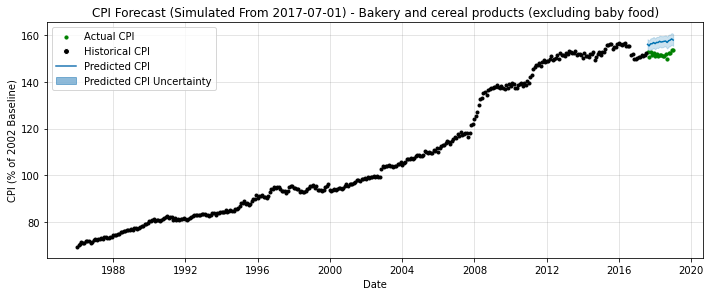

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -25.511
mae          5.144
mape         0.034
mse         27.419
rmse         5.236
dtype: float64
Initial log joint probability = -2.50119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1428.73    0.00131008       331.327           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1460.53     0.0182651       1739.82           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1480.44    0.00292943       1305.92      0.4638           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1493.06    0.00252553       585.098           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1495.02    0.00112915     

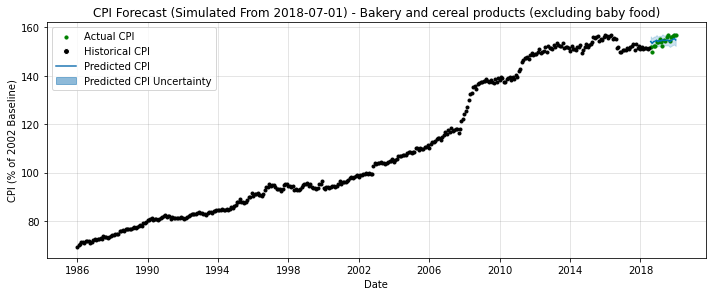

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.278
mae         1.404
mape        0.009
mse         2.882
rmse        1.698
dtype: float64
Initial log joint probability = -2.48641
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1503.42    0.00541551       907.579           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1525.02    0.00433444        238.52      0.9899      0.9899      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1541.35      0.012662       696.646           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1554.62    0.00585315       223.711      0.2856           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1559.11    0.00098338       112

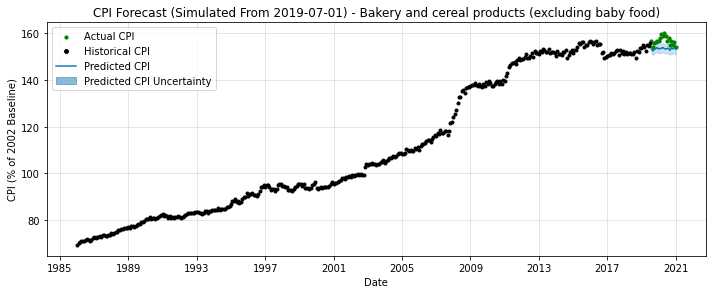

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.390
mae          3.542
mape         0.022
mse         14.774
rmse         3.844
dtype: float64
Initial log joint probability = -2.47511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1558.64    0.00232175       337.681           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1576.38    0.00160444       281.528           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1587.44     0.0297718       853.589           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1603.37     0.0177083        2166.2       5.326      0.5326      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403       1604.19   0.000128044     

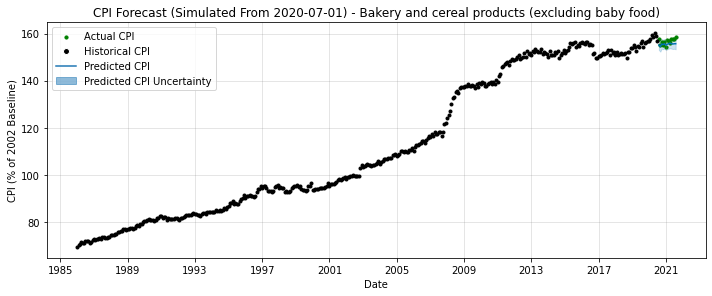

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.808
mae         1.401
mape        0.009
mse         2.737
rmse        1.654
dtype: float64
Initial log joint probability = -2.27694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1505.05    0.00745691       3191.36           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1547.75    0.00459628       791.048           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1560.65     0.0112989       1360.87           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1566.5    0.00101248       778.327      0.3752           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1570.24    0.00205602       532

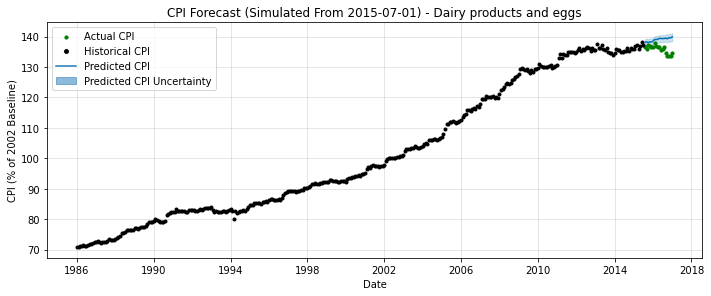

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.629
mae          3.144
mape         0.023
mse         12.841
rmse         3.583
dtype: float64
Initial log joint probability = -2.27357
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1579.67    0.00133351       921.886           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1612.77    0.00102056       442.306           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1618.89   0.000162102       403.578       0.227       0.227      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1625.2    0.00024843       190.529      0.4749      0.4749      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1627.22   0.000125613     

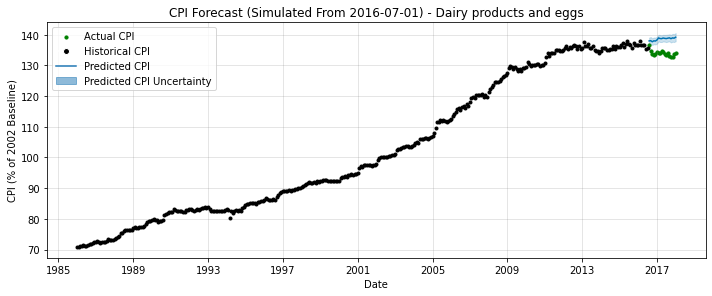

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -29.860
mae          4.628
mape         0.035
mse         22.604
rmse         4.754
dtype: float64
Initial log joint probability = -2.37705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1607.56    0.00245429       1301.86           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1637.15    0.00119947       582.773      0.1337           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1650.76   0.000327023       264.853      0.7082      0.7082      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       1658.46   5.91795e-05       534.897   1.243e-07       0.001      474  LS failed, Hessian reset 
     399       1658.95   0.000744063       501.473           1           1      497   
    Iter      log prob

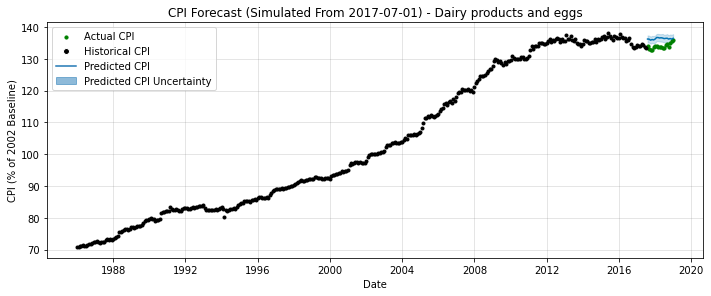

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -7.984
mae         2.385
mape        0.018
mse         6.349
rmse        2.520
dtype: float64
Initial log joint probability = -2.4619
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1665.21     0.0058353       1409.87           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1707.23    0.00304671       432.634           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1728.42    0.00292434        1165.1           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1737.47   0.000455848       284.327           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1743.67   0.000241545        629

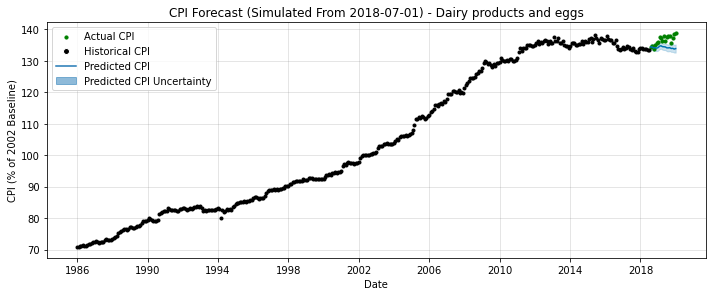

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -2.499
mae         2.372
mape        0.017
mse         7.719
rmse        2.778
dtype: float64
Initial log joint probability = -2.37086
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1734.51     0.0106826        2105.9           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1762.05     0.0110395       5466.59      0.3918           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1776.7    0.00192464       211.632       1.394      0.1394      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1785.47    0.00148243       965.628           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1788.29    0.00164057       356

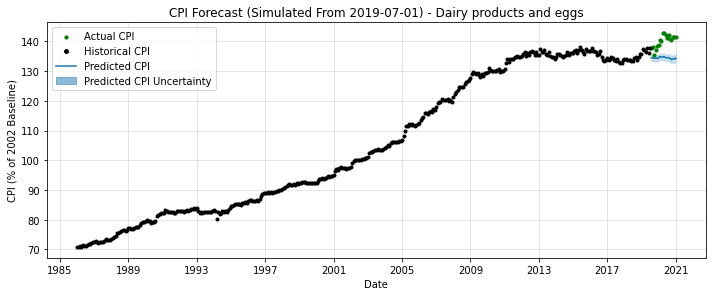

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -7.843
mae          5.756
mape         0.041
mse         37.203
rmse         6.099
dtype: float64
Initial log joint probability = -2.31087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1712.76     0.0013172        367.59           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1737.54    0.00387215       733.962      0.4016       0.815      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1740.93   8.37081e-05       135.363           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1743.52   0.000519435       734.723           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1745.29   0.000412478     

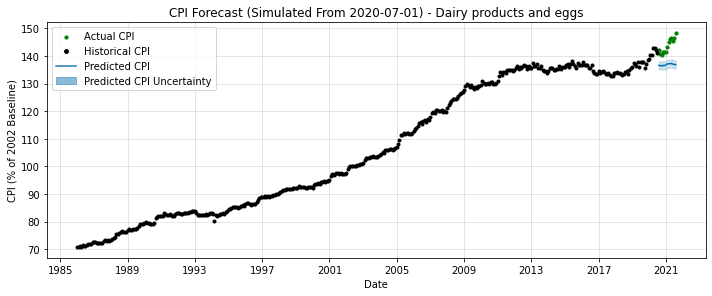

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -7.482
mae          6.909
mape         0.048
mse         52.973
rmse         7.278
dtype: float64
Initial log joint probability = -2.39071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1267.69    0.00287231       346.512           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1286.94     0.0013556       123.577      0.3972           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1286.95   6.42342e-05       132.999   5.198e-07       0.001      265  LS failed, Hessian reset 
     299       1291.34   8.17447e-05       121.699       0.852       0.852      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1292.99     0.0111339       576.276           1           1      514   
    Iter      log prob

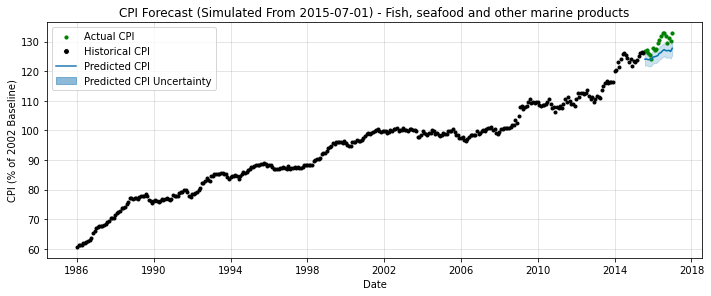

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.053
mae          3.522
mape         0.027
mse         14.759
rmse         3.842
dtype: float64
Initial log joint probability = -2.52016
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1319.8    0.00659616       314.433           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1346.1   0.000702034        297.29      0.8111      0.8111      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1355.31    0.00127259        354.66           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1357.85    0.00445013       395.672      0.4696           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     484       1361.31   3.47472e-05     

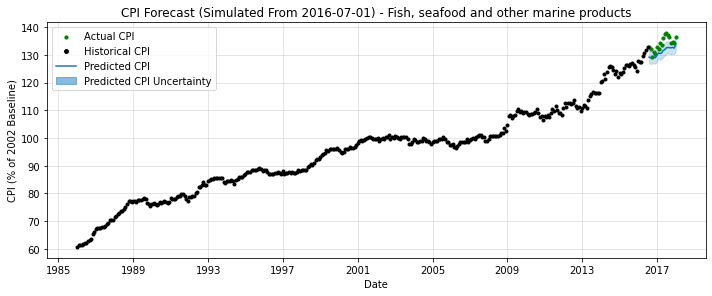

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -0.790
mae          2.971
mape         0.022
mse         10.869
rmse         3.297
dtype: float64
Initial log joint probability = -2.63227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1384.88    0.00343044       819.763           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1420.38    0.00771906       699.644           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1430.37     0.0129319       469.673           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1434.5   0.000398969       299.757      0.5294      0.5294      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     462       1436.17   0.000126422     

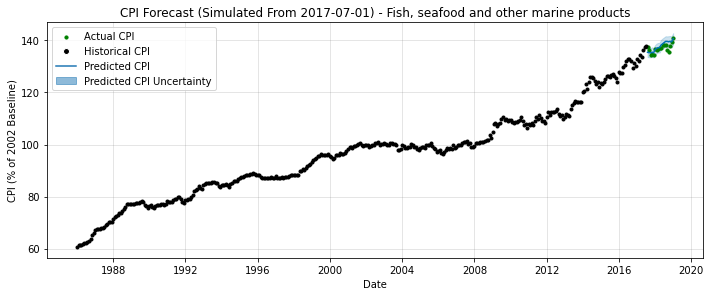

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.175
mae         1.122
mape        0.008
mse         2.222
rmse        1.491
dtype: float64
Initial log joint probability = -2.51039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1454.74      0.015086       205.318           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1492.57    0.00154555       696.935           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1507.56    0.00142492       699.944           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1514.04    0.00517969        402.56           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1515.02    0.00118872       295

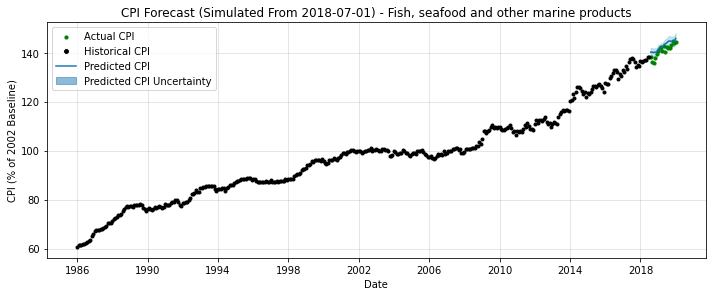

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.310
mae         1.702
mape        0.012
mse         4.524
rmse        2.127
dtype: float64
Initial log joint probability = -2.56655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1524.84     0.0121572       2088.59           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1558.63    0.00024448       157.011      0.8123      0.8123      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1570.31    0.00209606       847.696           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     396          1573    5.0409e-05       263.747   1.397e-07       0.001      504  LS failed, Hessian reset 
     399       1573.01   7.78637e-05       210.604           1           1      507   
    Iter      log prob     

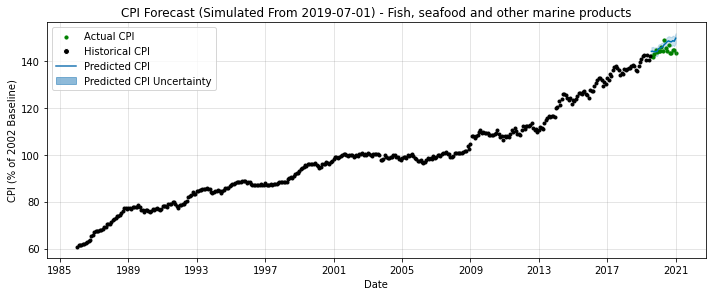

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -2.396
mae         2.412
mape        0.017
mse         8.848
rmse        2.975
dtype: float64
Initial log joint probability = -2.50884
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1573.46     0.0533181       1830.91           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1616.13   0.000535404       281.223      0.3371           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1624.86    0.00176375       627.564           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1631.05    0.00157883       458.873      0.3318      0.3318      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495       1632.51   2.89908e-05       172

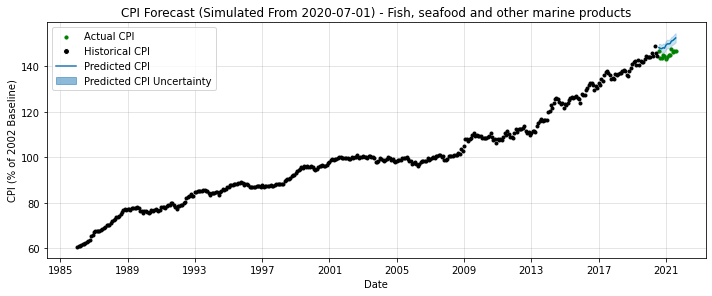

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -10.342
mae          4.456
mape         0.031
mse         21.455
rmse         4.632
dtype: float64
Initial log joint probability = -2.0862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1640.01   0.000570357       1361.59      0.1606      0.1606      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1717.66   0.000494228       1309.98           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1738.13    0.00380891       1530.41      0.3183      0.3183      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1758.55    0.00019216        345.76           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1766.86    0.00417893      

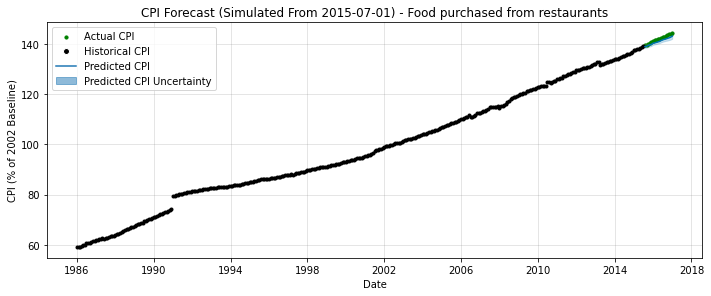

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.550
mae         0.972
mape        0.007
mse         1.023
rmse        1.011
dtype: float64
Initial log joint probability = -2.09869
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1685.31     0.0357074       3177.69           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1743.11    0.00536178       4699.14      0.5175      0.5175      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1794.61     0.0264958       3360.87           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1818.52   0.000510901       1128.89      0.9801      0.9801      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1826.16   0.000150501       209

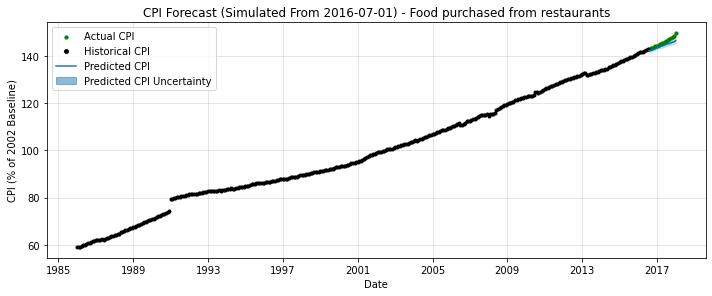

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.303
mae         1.422
mape        0.010
mse         2.436
rmse        1.561
dtype: float64
Initial log joint probability = -2.11409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1766.18    0.00716633       1145.38           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1843.08    0.00966598       5233.39           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1861.37   0.000245122       634.457      0.8374      0.8374      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1868.91    0.00369474        1927.6           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1876.54   0.000597958       485

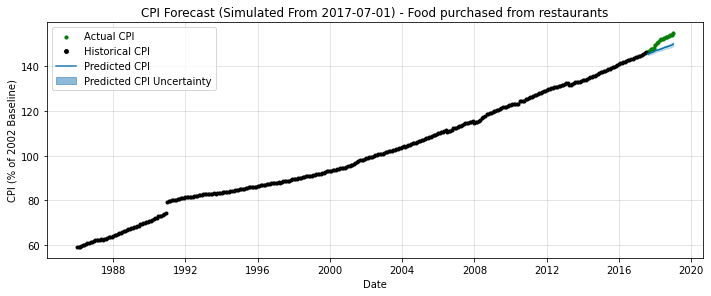

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.011
mae          3.470
mape         0.023
mse         13.912
rmse         3.730
dtype: float64
Initial log joint probability = -2.21958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1757.68    0.00328647       1112.79      0.2836       0.837      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1833.52     0.0130412       3578.98      0.5273      0.5273      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1850.29    0.00587969       2162.06           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1863.29    0.00147759       2945.97           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1870.65   7.31657e-05     

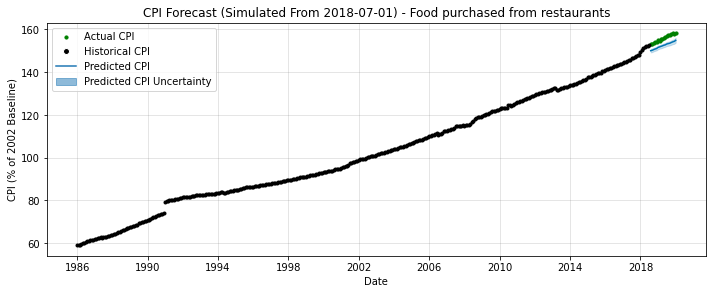

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -3.029
mae          3.447
mape         0.022
mse         12.036
rmse         3.469
dtype: float64
Initial log joint probability = -2.25413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.14    0.00199406       2161.17      0.6199      0.6199      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1874.18    0.00190156       488.478           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1897.66   0.000973113       643.018           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1905.83   0.000105245       392.844           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1909.5    0.00136188     

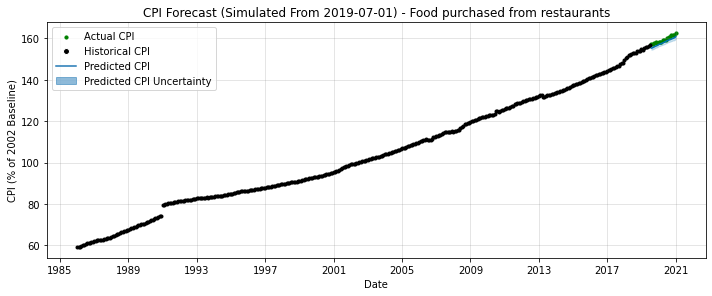

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.144
mae         1.447
mape        0.009
mse         2.241
rmse        1.497
dtype: float64
Initial log joint probability = -2.25978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1899.11    0.00153591       5793.85     0.04678           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1964.74    0.00847747        5726.5           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2011.57    0.00199285       1030.38           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2030.04   0.000384756       361.629           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2043.73     0.0006295       598

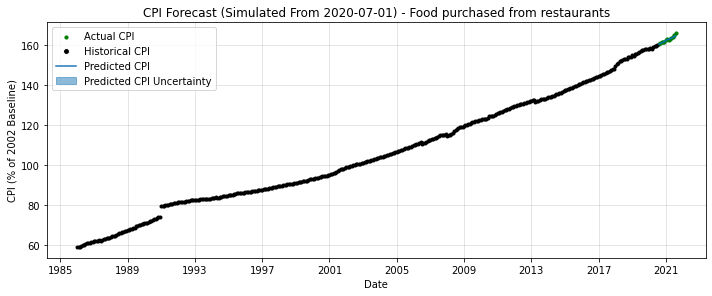

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.882
mae         0.360
mape        0.002
mse         0.271
rmse        0.521
dtype: float64
Initial log joint probability = -2.33711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1579.58   0.000544302       431.234           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1611.71    0.00584774       1899.66           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1621.74    0.00073477       730.677      0.7698      0.7698      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1625.68   0.000117166       291.501      0.4507      0.4507      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1627.38    0.00237261       100

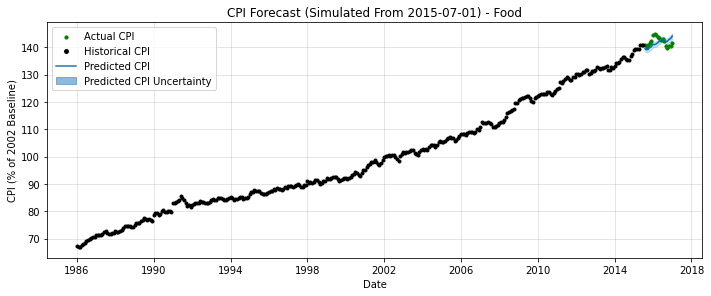

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.857
mae         1.893
mape        0.013
mse         4.727
rmse        2.174
dtype: float64
Initial log joint probability = -2.31054
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1631.11   0.000823879       622.577           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1650.67    0.00255733       1515.49           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1660.68    0.00221983       1804.61       0.502           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1663.19   3.71127e-05       91.4783           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1664.96    0.00018365        33

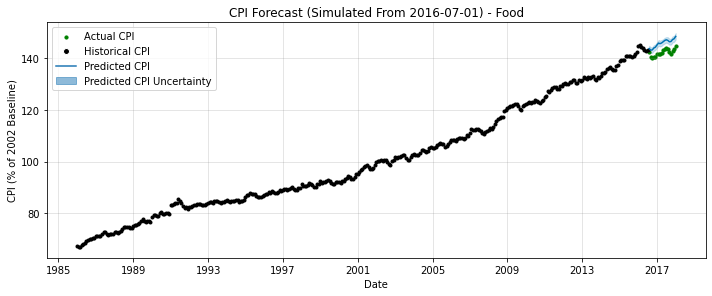

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.449
mae          3.531
mape         0.025
mse         12.963
rmse         3.600
dtype: float64
Initial log joint probability = -2.2499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1661.82   0.000509172       313.806           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1671.23   0.000659862       390.979      0.9981      0.9981      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1674.89    0.00295647       638.049           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1676.4   7.39811e-05       212.091      0.3653      0.3653      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1676.96    0.00244417      

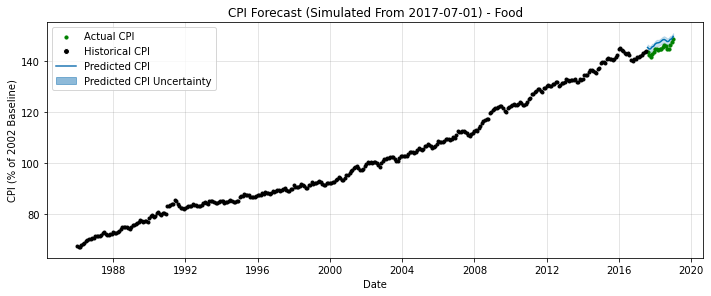

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -1.114
mae         2.364
mape        0.016
mse         5.941
rmse        2.437
dtype: float64
Initial log joint probability = -2.23278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1697.62    0.00301029       1726.23           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1710.1   0.000980399       466.381           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1719.35    0.00757694       904.962           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1722.56    0.00060634        352.11      0.5215      0.5215      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1724.34   0.000299402       491

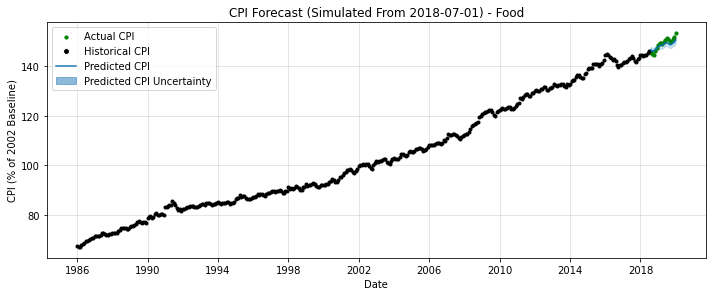

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.676
mae         1.236
mape        0.008
mse         1.910
rmse        1.382
dtype: float64
Initial log joint probability = -2.3316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1764.52    0.00046576       1129.12      0.4548      0.4548      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1781.92   0.000918291       454.164           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1787.67   0.000259101        802.11      0.3282           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1789.91   0.000781538        230.56           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1793.89     0.0086839       1162

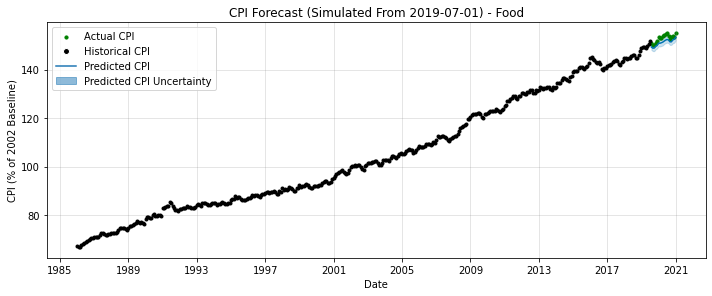

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.668
mae         1.903
mape        0.012
mse         3.906
rmse        1.976
dtype: float64
Initial log joint probability = -2.3579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1809.17    0.00895136       2701.62           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.26    0.00373734       1730.85      0.1514           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.13   0.000763587       166.676      0.4969           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.56   0.000602089       425.958           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1843.28   0.000506392       723.

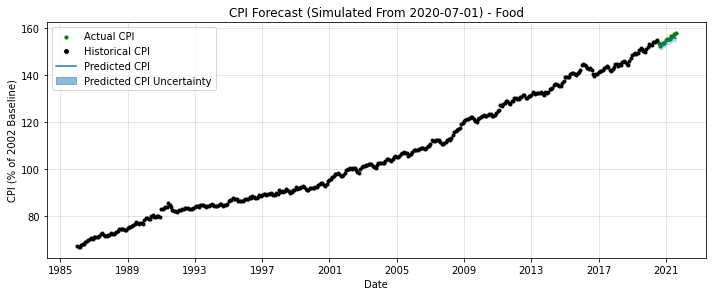

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.569
mae         0.940
mape        0.006
mse         1.161
rmse        1.078
dtype: float64
Initial log joint probability = -2.90205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1130.46    0.00902842           814           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159        1132.9   9.35958e-05       102.747   8.864e-07       0.001      237  LS failed, Hessian reset 
     199       1133.28   0.000111506       69.6877      0.3165      0.3165      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       1134.38   0.000263809       204.365   2.526e-06       0.001      407  LS failed, Hessian reset 
     299       1134.44   0.000259342       96.3588      0.4526      0.4526      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
   

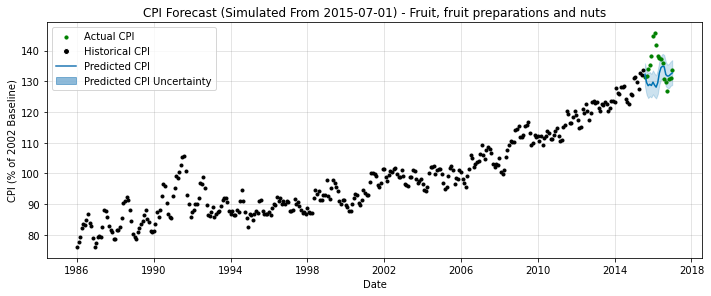

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.228
mae          5.628
mape         0.041
mse         56.842
rmse         7.539
dtype: float64
Initial log joint probability = -2.79024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1175.46    0.00124294       391.622      0.8499      0.8499      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1180.06   5.73299e-05       72.3927      0.4854      0.4854      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1180.6    6.7567e-06       73.4583      0.3797           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382        1180.9   0.000351363       123.746   4.029e-06       0.001      515  LS failed, Hessian reset 
     399       1181.07   0.000181131       99.8369      0.7951      0.7951      534   
    Iter      log prob

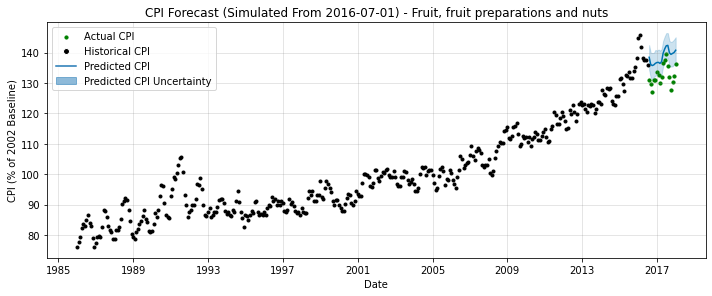

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.928
mae          6.115
mape         0.047
mse         43.044
rmse         6.561
dtype: float64
Initial log joint probability = -2.9315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       1211.13   0.000108466       109.198   5.549e-07       0.001      162  LS failed, Hessian reset 
      99       1211.13   4.64596e-05       84.0653           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       1214.36   0.000211317       118.285   1.477e-06       0.001      313  LS failed, Hessian reset 
     199       1214.42    0.00116162       84.9558           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       1214.64   1.10018e-05       63.5484   1.792e-07       0.001      436  LS failed, Hessian reset 
     287       1214.64   2.69498e-08       65.2382      0.2918     

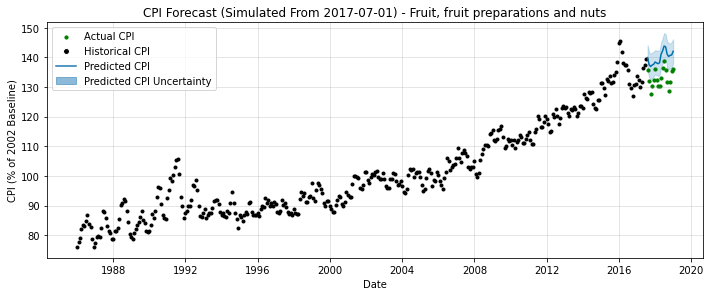

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.845
mae          6.841
mape         0.052
mse         51.421
rmse         7.171
dtype: float64
Initial log joint probability = -2.73356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1241.53    0.00387477       128.534      0.2927           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178        1244.7   0.000324182       215.341   2.055e-06       0.001      262  LS failed, Hessian reset 
     199       1244.82   1.62938e-05       67.7396      0.4708      0.4708      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1245.86   6.12509e-05       76.3068           1           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1246.01   0.000149572       60.6542       0.907       0.907      534   
    Iter      log prob

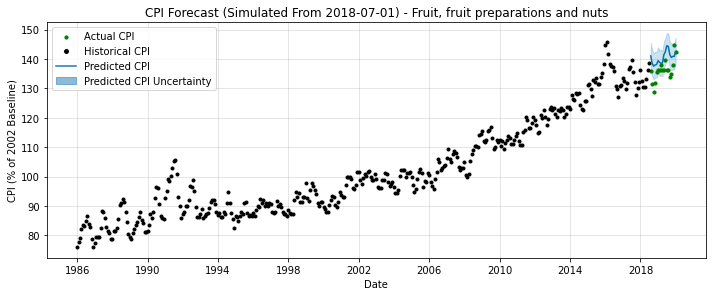

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.121
mae          4.625
mape         0.034
mse         28.013
rmse         5.293
dtype: float64
Initial log joint probability = -2.51446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1274.46    0.00040127       111.432      0.6693      0.6693      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1277.91    0.00360915       256.683           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       1278.57   0.000161769       132.619    4.87e-07       0.001      349  LS failed, Hessian reset 
     287       1279.23   0.000100387       122.291   1.053e-06       0.001      472  LS failed, Hessian reset 
     299       1279.37   0.000784715       84.4555           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

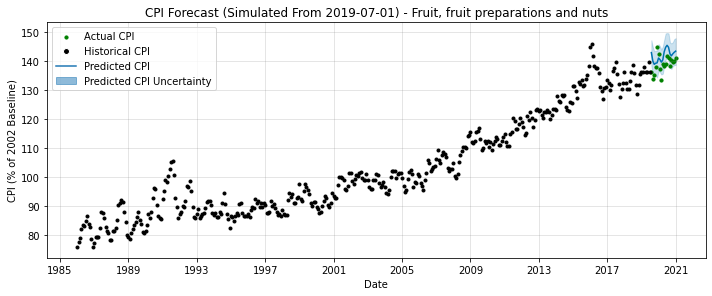

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.040
mae          3.783
mape         0.027
mse         17.264
rmse         4.155
dtype: float64
Initial log joint probability = -2.69346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1309.37   0.000800939       90.8979           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1314.4    0.00787174        202.65           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       1315.89   0.000199828       184.602   1.496e-06       0.001      350  LS failed, Hessian reset 
     299       1316.72   6.46644e-05       64.3356      0.2724           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       1317.18   0.000183321        179.42   1.638e-06       0.001      546  LS failed, Hessian reset

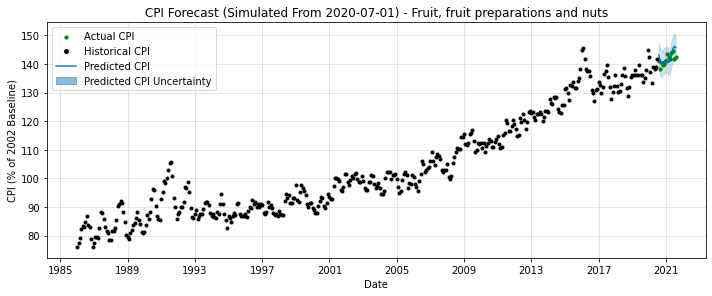

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.335
mae         1.611
mape        0.011
mse         4.101
rmse        2.025
dtype: float64
Initial log joint probability = -3.52442
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1281.14    0.00846514       978.506           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1291.67    0.00497729       170.143           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1295.54    0.00116231       167.011           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       1296.84   6.57506e-05        170.53   2.894e-07       0.001      468  LS failed, Hessian reset 
     399       1298.52   0.000533068       216.506      0.9566      0.9566      530   
    Iter      log prob     

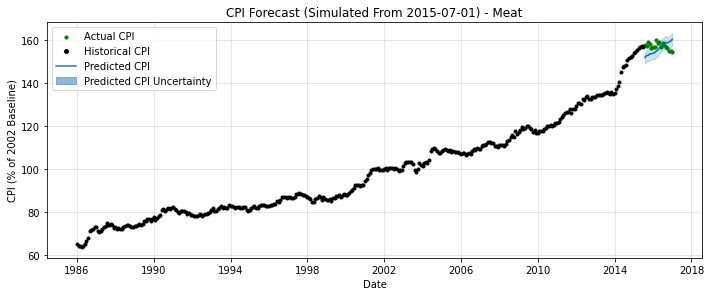

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -5.740
mae          3.509
mape         0.022
mse         15.299
rmse         3.911
dtype: float64
Initial log joint probability = -3.3323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1338.9     0.0056426       387.734           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1356.36    0.00231409       515.838      0.3764      0.3764      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.97   0.000670033       585.482      0.5552      0.5552      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1366.7    0.00174566       546.655      0.9012      0.9012      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421        1367.8   0.000116691      

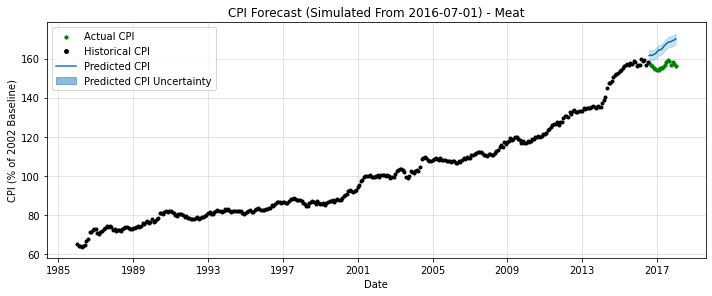

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -41.610
mae          9.150
mape         0.058
mse         89.917
rmse         9.482
dtype: float64
Initial log joint probability = -3.07077
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.85    0.00799517       195.919           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1365.69    0.00152919       167.889           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       1367.72   3.51114e-05        98.596   2.979e-07       0.001      409  LS failed, Hessian reset 
     299       1367.74   0.000316692       104.495           1           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       1368.33   9.41549e-05       74.2666   1.458e-06       0.001      513  LS failed, Hessian reset

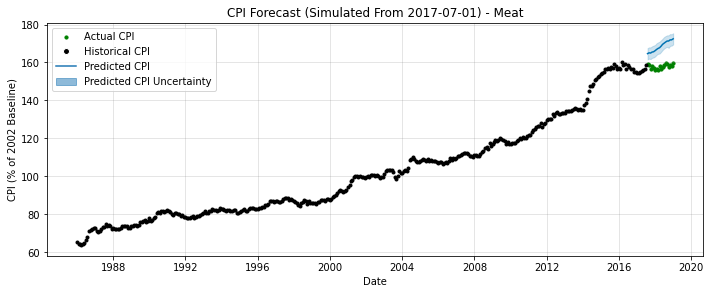

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -78.918
mae          10.500
mape          0.066
mse         115.894
rmse         10.765
dtype: float64
Initial log joint probability = -2.88274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.56   0.000266875       97.1952      0.1102           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       1363.58   0.000134748       145.459   7.062e-07       0.001      232  LS failed, Hessian reset 
     199       1364.23    0.00092522       207.862           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1365.26    0.00105887       157.903      0.2938           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371        1365.6   5.20089e-05       108.776   9.796e-07       0.001      550  LS failed, Hessian 

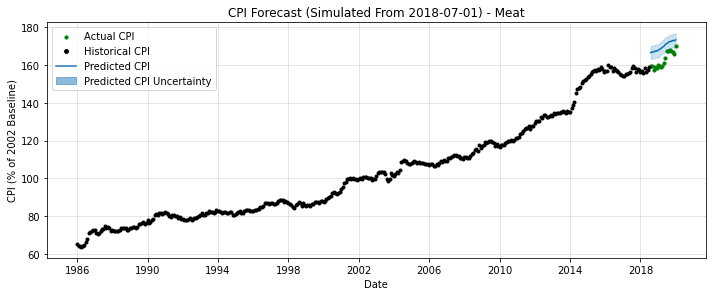

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.272
mae          7.166
mape         0.044
mse         55.679
rmse         7.462
dtype: float64
Initial log joint probability = -3.2237
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1395.09    0.00442463       157.458           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       1397.03   0.000146257       217.917   7.762e-07       0.001      193  LS failed, Hessian reset 
     199       1398.81      0.009287       348.944      0.5091           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1400.59    0.00537383       209.651           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1401.54    0.00139344       127.226      0.3279           1      518   
    Iter      log prob 

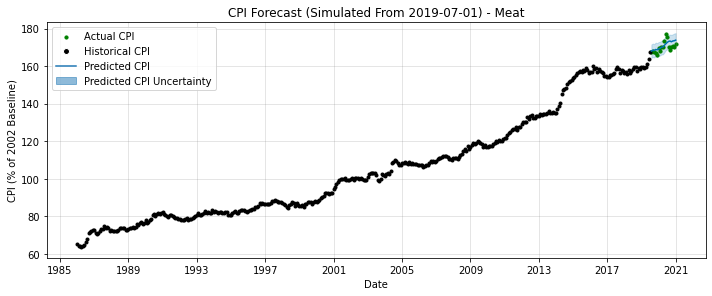

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.195
mae         2.095
mape        0.012
mse         6.411
rmse        2.532
dtype: float64
Initial log joint probability = -3.5247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.47    0.00595469       228.308           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1476.25    0.00242354       450.228      0.3079      0.9422      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1479.4     0.0062632       203.452           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1481.12   0.000399986       63.9702           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       1481.57   7.28073e-05       165.

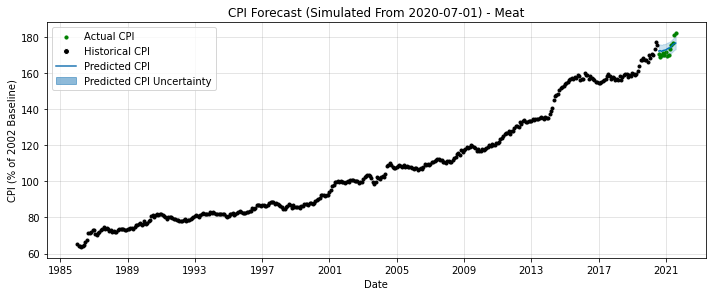

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.523
mae         2.453
mape        0.014
mse         8.499
rmse        2.915
dtype: float64
Initial log joint probability = -2.2565
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1323.39    0.00704849       270.089           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1348.57    0.00995684       1133.52      0.1463      0.7767      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1355.48    0.00125411       150.638       1.507      0.1507      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.58    0.00371333        475.84      0.6676      0.6676      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1370.19     0.0101207       273.

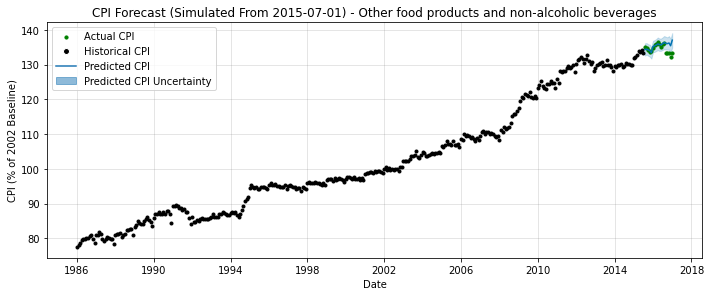

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.902
mae         1.088
mape        0.008
mse         2.725
rmse        1.651
dtype: float64
Initial log joint probability = -2.26887
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1404.38      0.036358       1543.77           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1445.75    0.00433503       249.802           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       1459.57   6.49057e-05       232.976   2.614e-07       0.001      376  LS failed, Hessian reset 
     299       1460.09    0.00165652       1433.98      0.3297           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1463.35    0.00220368       577.601           1           1      494   
    Iter      log prob     

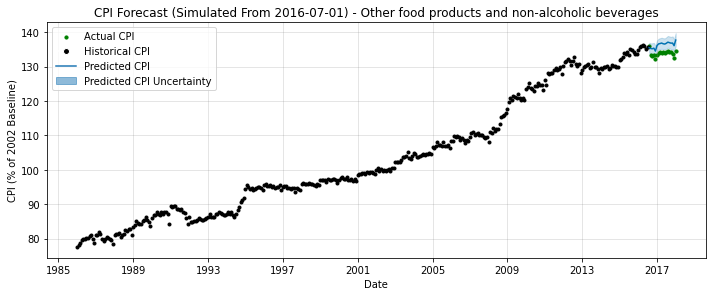

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -8.263
mae         2.484
mape        0.019
mse         6.561
rmse        2.561
dtype: float64
Initial log joint probability = -2.18937
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1448.07    0.00181749         902.2           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1502.17    0.00271455        306.28      0.4929      0.9574      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1518.08   0.000723505       229.096           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1522.7   0.000148859       260.674       0.143           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1527.59    0.00159614       388

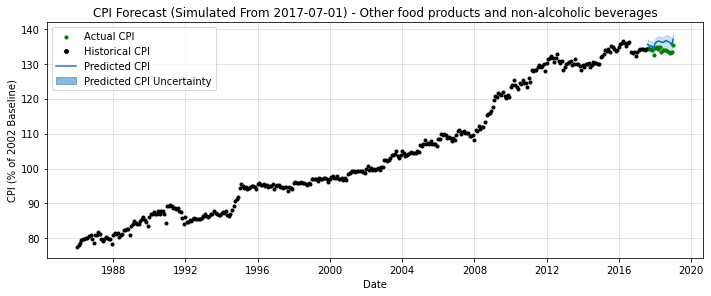

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -7.788
mae         1.944
mape        0.015
mse         4.298
rmse        2.073
dtype: float64
Initial log joint probability = -2.17846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1507.11    0.00147941        648.67      0.4895      0.4895      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1551.33     0.0187636       1137.26           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1567.55    0.00608588       855.599      0.6181           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1574.55    0.00793487       846.222      0.4412      0.4412      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     492       1578.56   5.46898e-05       135

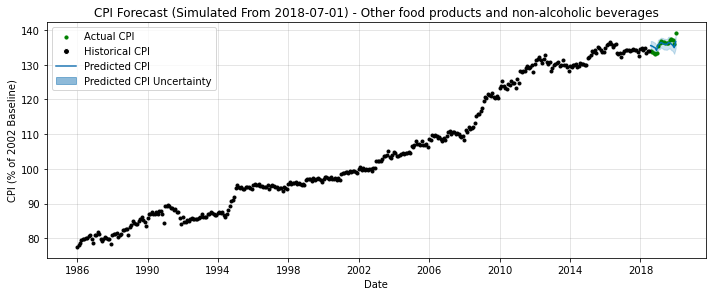

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.464
mae         0.955
mape        0.007
mse         1.411
rmse        1.188
dtype: float64
Initial log joint probability = -2.17779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1543.96      0.005584       3903.65           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1589.56    0.00814544       515.067           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1603.18   0.000724509       1177.82      0.3679      0.3679      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1617.9      0.016755       980.175           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1624.39   0.000953571       92.

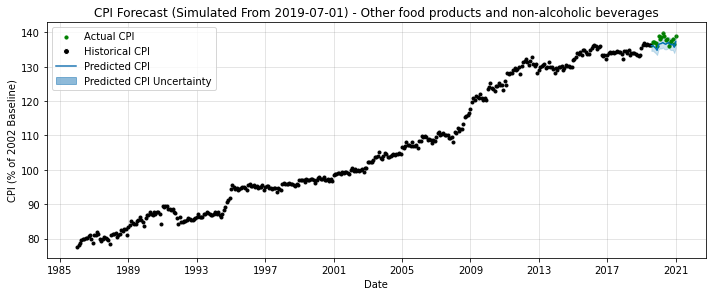

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.976
mae         1.408
mape        0.010
mse         2.430
rmse        1.559
dtype: float64
Initial log joint probability = -2.17091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1620.28     0.0388212       1031.41           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1665.47      0.001971       217.942           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1675.2    0.00113474       1169.58      0.6672      0.6672      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1683.94   0.000282944       301.075      0.5994      0.5994      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1686.52    0.00109923       407

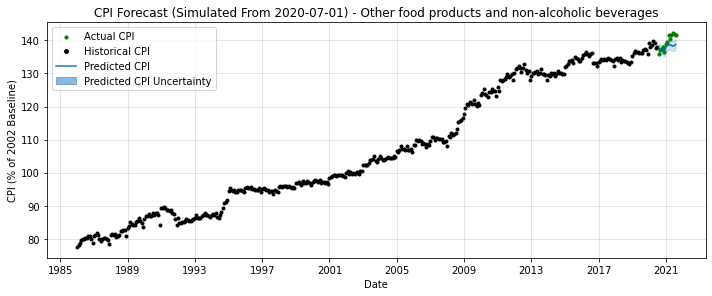

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.039
mae         1.785
mape        0.013
mse         4.908
rmse        2.215
dtype: float64
Initial log joint probability = -3.86358
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       961.967    0.00157717       163.988   2.401e-05       0.001      159  LS failed, Hessian reset 
      99       961.975   0.000501977       184.731           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       963.286   2.83636e-05       63.4525           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207        963.38   0.000595869       200.468   6.778e-06       0.001      343  LS failed, Hessian reset 
     255       963.437   3.52343e-08       68.7619      0.1954           1      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below

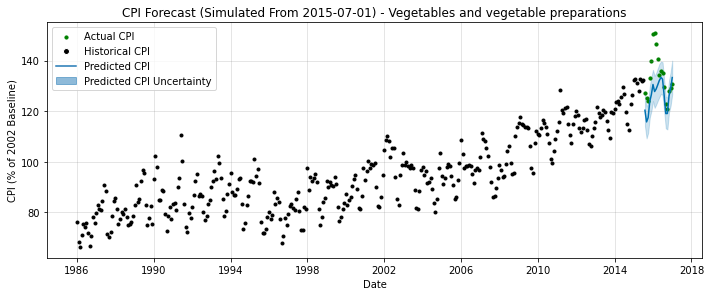

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     -0.308
mae           7.628
mape          0.055
mse         102.929
rmse         10.145
dtype: float64
Initial log joint probability = -3.5538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1025.63    0.00113994       83.7859           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       1026.89   0.000208098        97.295   1.702e-06       0.001      259  LS failed, Hessian reset 
     199       1027.28   0.000627911       70.5051           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       1027.43   0.000112553       55.6965   1.694e-06       0.001      453  LS failed, Hessian reset 
     299       1027.43   8.13051e-06       49.8542           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

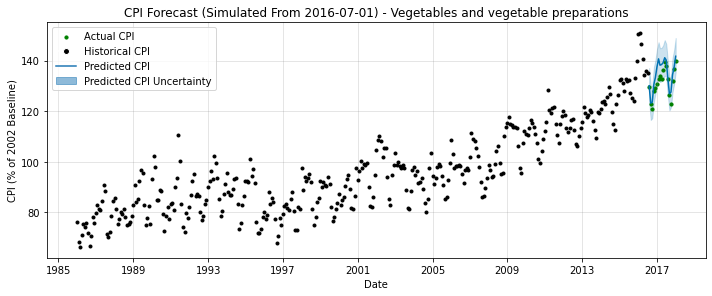

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.568
mae          2.905
mape         0.022
mse         13.017
rmse         3.608
dtype: float64
Initial log joint probability = -3.6296
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1062.03   0.000364363       115.113      0.7842      0.7842      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       1063.58    0.00032223       120.088   5.387e-06       0.001      230  LS failed, Hessian reset 
     199       1063.87   0.000467555       72.2712      0.3171      0.7492      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       1064.06     0.0002002       61.5776   2.709e-06       0.001      383  LS failed, Hessian reset 
     299       1064.13   1.09595e-05       73.4287       0.407           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

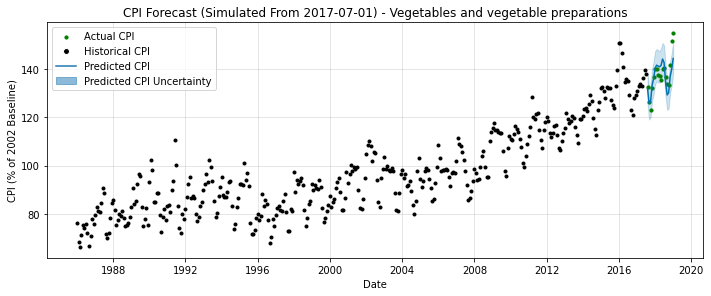

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.577
mae          3.636
mape         0.026
mse         23.157
rmse         4.812
dtype: float64
Initial log joint probability = -3.70272
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1099.85    0.00422832       167.894      0.4502           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1100.98     0.0006747       100.192   9.486e-06       0.001      185  LS failed, Hessian reset 
     199       1101.69    0.00256848       53.0296           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       1101.74   0.000242513       106.887   3.439e-06       0.001      335  LS failed, Hessian reset 
     299       1102.13   0.000247656       76.3364           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

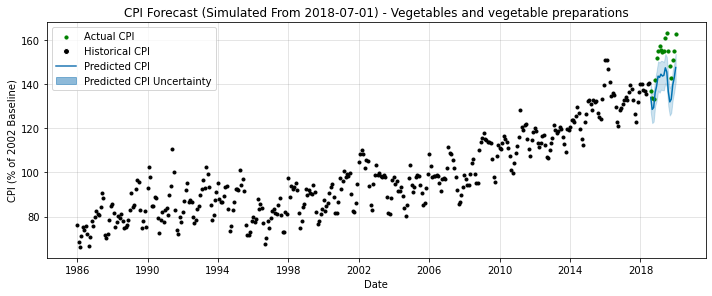

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     -0.763
mae          11.234
mape          0.073
mse         145.290
rmse         12.054
dtype: float64
Initial log joint probability = -6.20023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1155.65    0.00188544       182.372      0.8066      0.8066      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       1156.49   0.000296985       67.7444   4.093e-06       0.001      265  LS failed, Hessian reset 
     199        1156.5   3.02639e-05       64.6891      0.9803      0.2707      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       1157.38   0.000131595       87.1184   1.498e-06       0.001      457  LS failed, Hessian reset 
     299       1157.52   0.000478105       60.9251           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  

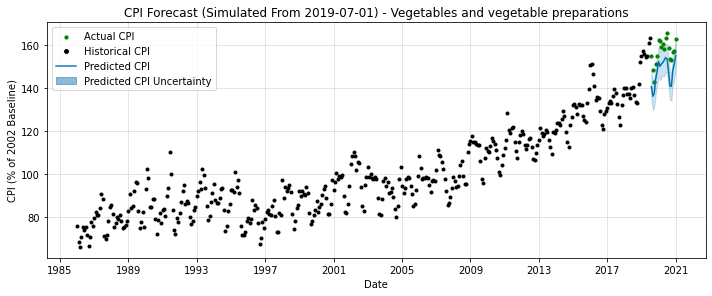

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.990
mae          9.329
mape         0.059
mse         94.073
rmse         9.699
dtype: float64
Initial log joint probability = -6.06447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1189.54     0.0013834       86.2939      0.2377      0.8223      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       1189.85   0.000243545       109.502    2.88e-06       0.001      161  LS failed, Hessian reset 
     187       1192.54   0.000192352       119.401   1.369e-06       0.001      293  LS failed, Hessian reset 
     199       1192.86   0.000257245       64.3428      0.2283           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1193.11   7.64314e-06       73.8212   1.289e-07       0.001      414  LS failed, Hessian reset 
     276       1193.11   1.59864e-07        63.628      0.1451    

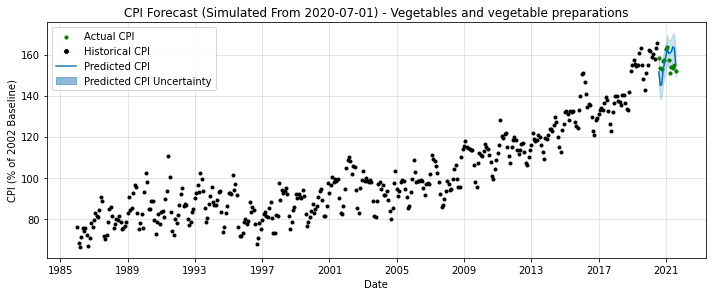

r2_score    -2.101
mae          5.819
mape         0.038
mse         42.909
rmse         6.550
dtype: float64


In [34]:
all_valid_metrics = {}
all_forecasts = {}

for food_category in foodprice_df.columns:

    annual_valid_metrics = {}
    annual_forecasts = {}

    for date in report_sim_dates:  

        train_dates = sim_train_dates[date]
        valid_dates = sim_valid_dates[date]

        model, valid_forecast, valid_metrics = fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates)
        valid_actual = get_prophet_df(foodprice_df, food_category, valid_dates) 

        plot_valid_forecast(model, food_category, date, valid_forecast, valid_actual)
        valid_metrics_series = pd.Series(valid_metrics)
        print(valid_metrics_series)

        annual_valid_metrics[date] = pd.DataFrame(valid_metrics_series).mean(axis=1)
        annual_forecasts[date] = valid_forecast.yhat

    all_valid_metrics[food_category] = annual_valid_metrics
    all_forecasts[food_category] = annual_forecasts

### Collect Validation Metrics and Save to File

In [35]:
mean_valid_metrics = {}
for food_category, valid_scores in all_valid_metrics.items():
    mean_valid_metrics[food_category] = pd.DataFrame(valid_scores).mean(axis=1)

mean_valid_metrics_df = pd.DataFrame(mean_valid_metrics).T
mean_valid_metrics_df.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_valid_metrics_df

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-13.203,4.089,0.027,26.060,4.470
Dairy products and eggs,-10.383,4.199,0.030,23.282,4.502
"Fish, seafood and other marine products",-2.349,2.698,0.019,10.446,3.060
Food purchased from restaurants,-0.360,1.853,0.012,5.320,1.965
Food,-1.307,1.978,0.014,5.101,2.108
"Fruit, fruit preparations and nuts",-1.916,4.767,0.035,33.447,5.457
Meat,-21.304,5.812,0.036,48.617,6.178
Other food products and non-alcoholic beverages,-2.917,1.611,0.012,3.722,1.875
Vegetables and vegetable preparations,-0.669,6.759,0.046,70.229,7.811


## Save Validation Forecasts to File (For Ensembling)

In [36]:
date_forecasts = {}
for date in report_sim_dates:
    valid_dates = sim_valid_dates[date]
    food_forecasts = {}
    for food_category in food_categories:
        food_forecasts[food_category] = all_forecasts[food_category][date]
    date_forecasts[date] = pd.DataFrame(food_forecasts)
    date_forecasts[date] = date_forecasts[date].set_index(pd.DatetimeIndex(valid_dates))
    date_forecasts[date].to_csv(f"{output_path}/forecasts_{date}.csv")

In [ ]:
## Fit Models Using All Data To Produce Final Forecast

In [40]:
def fit_final_forecast_model(foodprice_df, food_category, all_dates):
    train_df = get_prophet_df(foodprice_df, food_category, all_dates)       # Select data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    future = model.make_future_dataframe(periods=18, freq='MS')             # Create the future period. 
    forecast = model.predict(future.iloc[-18:])                             # Produce the future period forecast. 
    historical_fit = model.predict(future.iloc[:-18])                       # Look at how well the model fits the data.
    return model, forecast, historical_fit

In [41]:
def plot_final_forecast(model, forecast, historical_fit):

    fig = model.plot(forecast, figsize=(10,4))
    ax = fig.axes[0]

    ax.plot(historical_fit.ds, historical_fit.yhat, alpha=0.5, color='purple', label='Historical Model Fit')
    ax.fill_between(historical_fit.ds, historical_fit.yhat_lower, historical_fit.yhat_upper, 
                    alpha=0.2, color='purple', label='Historical Model Fit Uncertainty')
    ax.set_title(f'CPI Forecast - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_final_{food_category}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_final_{food_category}.png", bbox_inches='tight')
    plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


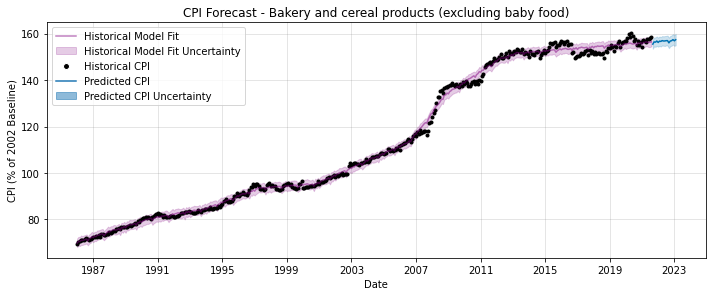

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


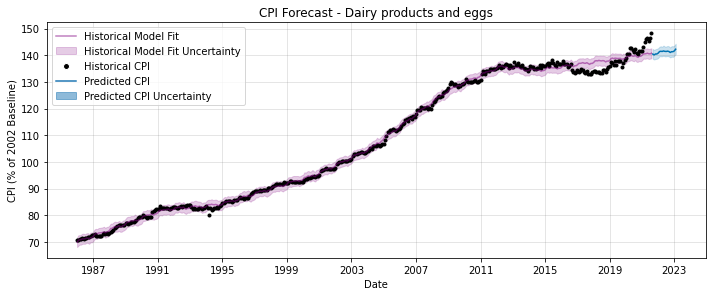

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


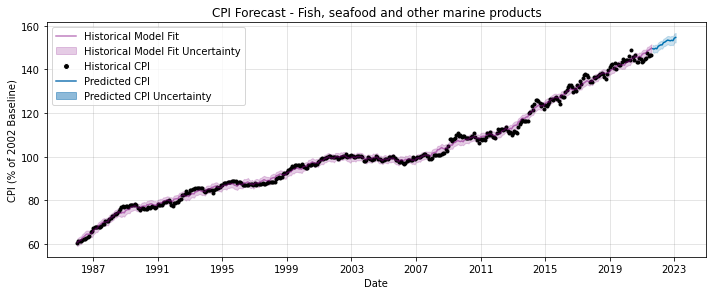

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


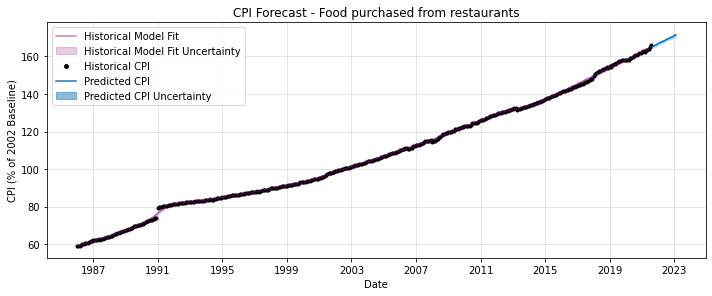

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


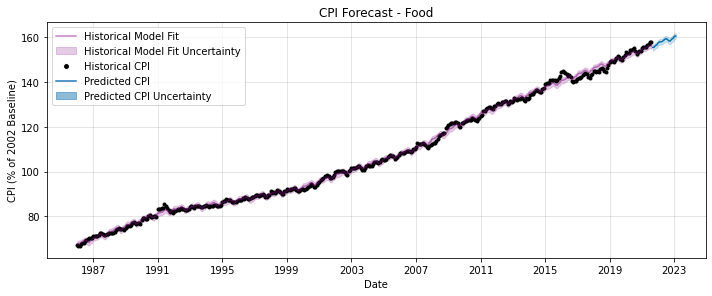

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


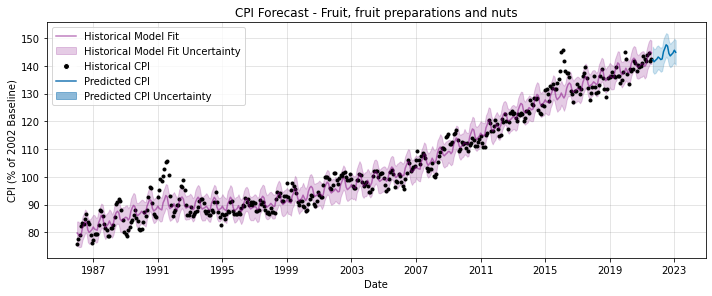

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


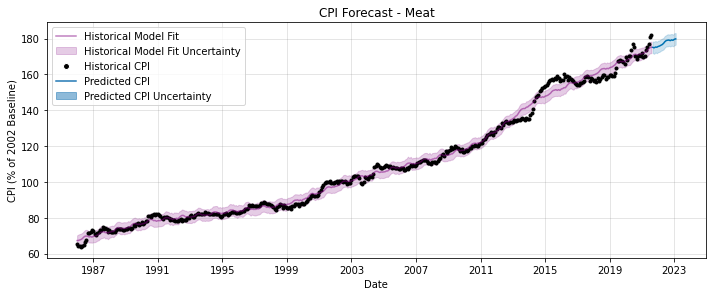

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


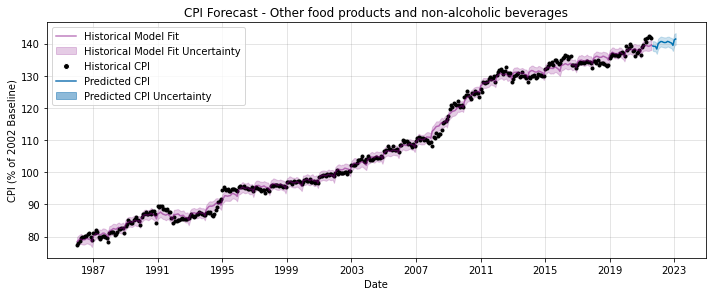

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


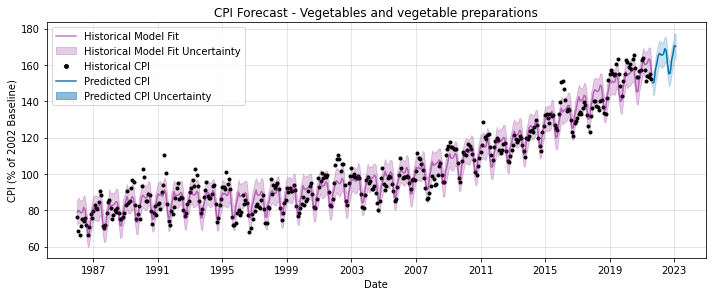

In [42]:
all_forecasts = {}

for food_category in foodprice_df.columns:

    model, forecast, historical_fit = fit_final_forecast_model(foodprice_df, food_category, all_dates=foodprice_df.index)
    plot_final_forecast(model, forecast, historical_fit)
    forecast.to_csv(f"{output_path}/fc_final_raw_{food_category}.csv")
    all_forecasts[food_category] = forecast

In [44]:
### Show all forecast details for Meat, as an example. 
# all_forecasts['Meat']

## Predicted Change in CPI By Category

For the report, we usually express forecasts as the predicted percentage change, overall for the next year. We can do this by comparing the mean forecasted CPI for 2022 to the mean (known and predicted) values for 2021.

In [46]:
historical_cpi_df = foodprice_df['Meat']
historical_cpi_df

REF_DATE
1986-01-01     65.1
1986-02-01     64.2
1986-03-01     64.2
1986-04-01     63.6
1986-05-01     64.0
              ...  
2021-04-01    173.5
2021-05-01    175.4
2021-06-01    176.7
2021-07-01    180.9
2021-08-01    182.1
Freq: MS, Name: Meat, Length: 428, dtype: float64

In [47]:
forecast_cpi_df = all_forecasts['Meat'][['ds', 'yhat']].set_index('ds')['yhat']
forecast_cpi_df

ds
2021-09-01    175.099
2021-10-01    174.829
2021-11-01    175.278
2021-12-01    175.165
2022-01-01    175.600
2022-02-01    175.830
2022-03-01    176.230
2022-04-01    176.618
2022-05-01    177.279
2022-06-01    178.242
2022-07-01    178.864
2022-08-01    179.066
2022-09-01    179.174
2022-10-01    178.837
2022-11-01    179.268
2022-12-01    179.013
2023-01-01    179.603
2023-02-01    179.831
Name: yhat, dtype: float64

In [48]:
combined_cpi_df = historical_cpi_df.append(forecast_cpi_df)
combined_cpi_df = combined_cpi_df.loc[combined_cpi_df.index < '2023-01-01']
combined_cpi_df

1986-01-01     65.100
1986-02-01     64.200
1986-03-01     64.200
1986-04-01     63.600
1986-05-01     64.000
               ...   
2022-08-01    179.066
2022-09-01    179.174
2022-10-01    178.837
2022-11-01    179.268
2022-12-01    179.013
Length: 444, dtype: float64

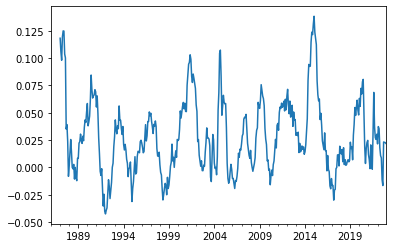

In [62]:
combined_cpi_df.pct_change(12).plot()

In [57]:
# mean_prediction = np.mean(combined_cpi_df[-12:].values - combined_cpi_df[-24:-12].values)
# std_prediction = np.std(combined_cpi_df[-12:].values - combined_cpi_df[-24:-12].values)
# print(mean_prediction, std_prediction)

2.787515528845629 2.7273027728817825


In [59]:
combined_cpi_df[-12:].values.mean() - combined_cpi_df[-24:-12].values.mean()

2.7875155288456313